Resources: https://drive.google.com/drive/folders/1Vrcc4ehz6maCpaI7-8EbiAH3UoFdGzEr?usp=sharing

In [0]:
import numpy as np
import pandas as pd
import random
import json
import datetime as dt
import time as tm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preprocessing

Do not run this section again as the data has already been processed and loaded in directories

In [0]:
#DONT RUN THIS; THIS IS THE CODE USED TO FILL MISSING VALUES IN ORGIGNAL DATA
tempList, index, col  = {}, 0, "KWH/hh (per half hour) "
for file in os.listdir('EnergyFiles'):
	if 'csv' not in file:
		continue
	name = './EnergyFiles/' + file
	df = pd.read_csv(name)
	df[col] = pd.to_numeric(df[col], errors = 'coerce')
	df["DateTime"] = pd.to_datetime(df["DateTime"], errors = 'coerce')
	df.sort_values(by=['LCLid','DateTime'], ascending = [True, True], inplace = True)
	df = df.ffill()
	df.to_csv('./EnergyFiles2/'+file)
	index = index + 1
	if index%10 == 0:
		print(index)

In [0]:
orignalFiles = []
for file in os.listdir('./EnergyFiles'):
  if 'csv' not in file:
    continue
  orignalFiles.append('./EnergyFiles/'+file)
orignalFiles.sort()


data = pd.DataFrame()
size = len(orignalFiles)
for i in range(size):
  tempData = pd.read_csv(orignalFiles[i])
  data = pd.concat([data, tempData])
  print(i)

In [0]:
filenames = []
prefix = 'Power-Networks-LCL-June2015(withAcornGps)v2_'
for i in range(1, 169):
    filenames.append(prefix+str(i)+'.csv')

print(filenames)

In [0]:
write_directory = "/content/drive/My Drive/DM Project/DayFiles"
read_directory = "EnergyFiles"
os.makedirs("/content/drive/My Drive/DM Project/DayFiles")

In [0]:
for f in filenames:
    df = pd.read_csv(read_directory+'/'+f)
    df['KWH/hh (per half hour) '] = df['KWH/hh (per half hour) '].astype(float)
    df['DateTime'] = df['DateTime'].astype('datetime64[ns]')
    write_file = open(write_directory+'/'+f, 'w')
    write_file.write('LCLid,stdorToU,DateTime,Acorn_grouped,KWH/week\n')
    i=0
    print(f)
    while i < len(df):
            current_time = df['DateTime'].iloc[i]
            current_house = df['LCLid'].iloc[i]
            new_house = current_house
            initial_week = current_time.week
            current_week = current_time.week
            energy_use = 0

            write_file.write(str(current_house)+',')
            write_file.write(str(df['stdorToU'].iloc[i])+',')
            write_file.write(str(current_time)+',')
            write_file.write(str(df['Acorn_grouped'].iloc[i])+',')

            while(current_time.week == initial_week and new_house == current_house and i < len(df)):
                energy_use += df['KWH/hh (per half hour) '].iloc[i]
                i+=1
                if(i < len(df)):
                    current_time = df['DateTime'].iloc[i]
                    new_house = df['LCLid'].iloc[i]
        
            write_file.write(str(energ uy_use)+'\n')

In [0]:
tariffs_data = pd.read_excel("/content/drive/My Drive/DM Project/Tariffs.xlsx")
tariffs_data.head()

,TariffDateTime,Tariff
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal


In [0]:
ToU_dataframe.to_csv('/content/drive/My Drive/DM Project/DynamicData.csv', index=False)

In [0]:
for i in range(len(ToU_dataframe)):
    print(i)
    dynamic_time = ToU_dataframe['DateTime'].iloc[i]
    if(dynamic_time.minute != 30 and dynamic_time.minute != 0):
        ToU_dataframe.drop(i, inplace=True)
    elif(dynamic_time.day == 29 and dynamic_time.month == 2):
        ToU_dataframe.drop(i, inplace=True)
    else:        
        label = tariffs_data.loc[tariffs_data['TariffDateTime'] == dynamic_time, 'Tariff'].iloc[0]
        ToU_dataframe.at[i, 'stdorToU'] = label

# Importing Data

Run the below section to import data. Add the data in the following directory structure so that the cell doesn't have to be changed over and over again. If you prefer to import data in a different way, add another cell in this section and place a comment on the top of the cell to identify it's purpose and user.

In [0]:
# This function takes the path to the directory that contains the CSV files as well as the number of files to read
def load_data(read_directory, start, files):
    filenames = []
    prefix = 'Power-Networks-LCL-June2015(withAcornGps)v2_'
    for i in range(start, files+1):
        filenames.append(prefix+str(i)+'.csv')

    li = []

    for f in filenames:
        df = pd.read_csv(read_directory+'/'+f, index_col=None, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [0]:
# You can specify the directory where the data is located here and the number of files you want to load
# This loads the weekly data for std tariff types
std_dataframe = load_data('/content/drive/My Drive/DM Project/DayFiles', 1, 90)

In [0]:
# This loads the half-hourly data for std tariff types
hourly_dataframe = load_data('/content/drive/My Drive/DM Project/EnergyFiles', 1, 3)

In [0]:
# This loads the Dynamic Tariff type data
ToU_dataframe = pd.read_csv('/content/drive/My Drive/DM Project/DynamicData.csv')

In [0]:
std_dataframe['DateTime'] = std_dataframe['DateTime'].astype('datetime64')
hourly_dataframe['DateTime'] = hourly_dataframe['DateTime'].astype('datetime64')
ToU_dataframe['DateTime'] = ToU_dataframe['DateTime'].astype('datetime64')

Some validation for whether your importing was successful

In [0]:
# Number of Rows in the data
print("Standard rows: ", str(len(std_dataframe.index)))
print("Hourly rows: ", str(len(hourly_dataframe.index)))
print("Dynamic rows: ", str(len(ToU_dataframe.index)))

Standard rows:  271016
Hourly rows:  3000000
Dynamic rows:  2930279


In [0]:
std_dataframe.head()

,LCLid,stdorToU,DateTime,Acorn_grouped,KWH/week
0,MAC000002,Std,2012-10-12 00:30:00,Affluent,31.408
1,MAC000002,Std,2012-10-15 00:00:00,Affluent,92.161
2,MAC000002,Std,2012-10-22 00:00:00,Affluent,109.615
3,MAC000002,Std,2012-10-29 00:00:00,Affluent,100.179
4,MAC000002,Std,2012-11-05 00:00:00,Affluent,80.747


In [0]:
hourly_dataframe.head()

,Unnamed: 0,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,0,MAC000002,Std,2012-10-12 00:30:00,0.0,ACORN-A,Affluent
1,1,MAC000002,Std,2012-10-12 01:00:00,0.0,ACORN-A,Affluent
2,2,MAC000002,Std,2012-10-12 01:30:00,0.0,ACORN-A,Affluent
3,3,MAC000002,Std,2012-10-12 02:00:00,0.0,ACORN-A,Affluent
4,4,MAC000002,Std,2012-10-12 02:30:00,0.0,ACORN-A,Affluent


In [0]:
ToU_dataframe.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn_grouped
0,MAC005157,Normal,2012-12-09 15:30:00,0.109,Adversity
1,MAC005157,Normal,2012-12-09 16:00:00,0.095,Adversity
2,MAC005157,Normal,2012-12-09 16:30:00,0.131,Adversity
3,MAC005157,Normal,2012-12-09 17:00:00,0.145,Adversity
4,MAC005157,Normal,2012-12-09 17:30:00,0.124,Adversity


In [0]:
hourly_dataframe.dtypes

Unnamed: 0                          int64
LCLid                              object
stdorToU                           object
DateTime                   datetime64[ns]
KWH/hh (per half hour)            float64
Acorn                              object
Acorn_grouped                      object
dtype: object

In [0]:
std_dataframe.dtypes

LCLid                    object
stdorToU                 object
DateTime         datetime64[ns]
Acorn_grouped            object
KWH/week                float64
dtype: object

In [0]:
ToU_dataframe.dtypes

LCLid                              object
stdorToU                           object
DateTime                   datetime64[ns]
KWH/hh (per half hour)            float64
Acorn_grouped                      object
dtype: object

# Summary Statistics

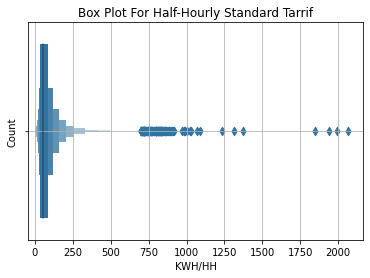

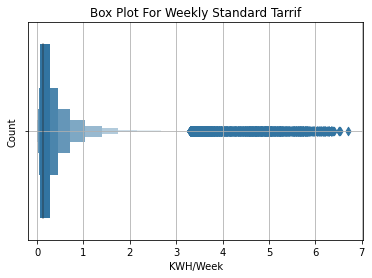

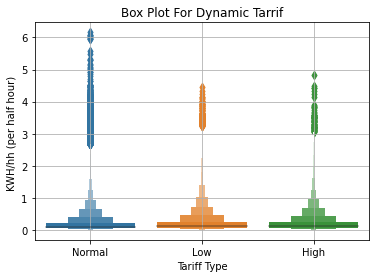

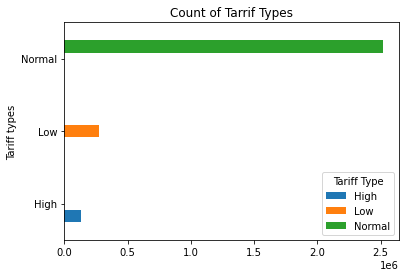

In [0]:
def summaryStats(df, group):
    if group == 3:
        ax = sns.boxenplot(x = 'stdorToU', y = 'KWH/hh (per half hour) ', data = df)
        ax.set(title = 'Box Plot For Dynamic Tarrif', xlabel = 'Tariff Type')
        plt.grid()
        plt.show()
        a = df.groupby('stdorToU').stdorToU.value_counts().unstack(0).plot.barh()
        a.set(title = 'Count of Tarrif Types', ylabel = 'Tariff types')
        a.legend(title = 'Tariff Type')
        return
    newdf = df.select_dtypes(include='float64')
    ax = sns.boxenplot(x = newdf)
    if group == 2:
        ax.set(title = 'Box Plot For Weekly Standard Tarrif', xlabel = 'KWH/Week', ylabel = 'Count')
    if group == 1:
        ax.set(title = 'Box Plot For Half-Hourly Standard Tarrif', xlabel = 'KWH/HH', ylabel = 'Count')
    ax.set()
    plt.grid()
    plt.show()
    

summaryStats(std_dataframe, 2)
summaryStats(hourly_dataframe, 1)
summaryStats(ToU_dataframe, 3)

### Number of Houses

In [0]:
def calculate_houses(df):
    return str(len(df['LCLid'].unique()))

In [0]:
print("Standard Dataframe: "+ calculate_houses(std_dataframe))
print("ToU Dataframe: "+ calculate_houses(ToU_dataframe))
print("Hourly Dataframe: "+ calculate_houses(hourly_dataframe))
print("Affluent Houses in Standard: "+ calculate_houses(std_dataframe[std_dataframe['Acorn_grouped'] == 'Affluent']))
print("Adverse Houses in Standard: "+ calculate_houses(std_dataframe[std_dataframe['Acorn_grouped'] == 'Adversity']))
print("Comfortable Houses in Standard: "+ calculate_houses(std_dataframe[std_dataframe['Acorn_grouped'] == 'Comfortable']))
print("ACORN-U Houses in Standard: "+ calculate_houses(std_dataframe[std_dataframe['Acorn_grouped'] == 'ACORN-U']))
print("Affluent Houses in Dynamic: "+ calculate_houses(ToU_dataframe[ToU_dataframe['Acorn_grouped'] == 'Affluent']))
print("Adverse Houses in Dynamic: "+ calculate_houses(ToU_dataframe[ToU_dataframe['Acorn_grouped'] == 'Adversity']))
print("Comfortable Houses in Dynamic: "+ calculate_houses(ToU_dataframe[ToU_dataframe['Acorn_grouped'] == 'Comfortable']))
print("ACORN-U Houses in Standard: "+ calculate_houses(ToU_dataframe[ToU_dataframe['Acorn_grouped'] == 'ACORN-']))
print("Affluent Houses in Hourly: "+ calculate_houses(hourly_dataframe[hourly_dataframe['Acorn_grouped'] == 'Affluent']))
print("Adverse Houses in Hourly: "+ calculate_houses(hourly_dataframe[hourly_dataframe['Acorn_grouped'] == 'Adversity']))
print("Comfortable Houses in Hourly: "+ calculate_houses(hourly_dataframe[hourly_dataframe['Acorn_grouped'] == 'Comfortable']))
print("ACORN-U Houses in Hourly: "+ calculate_houses(hourly_dataframe[hourly_dataframe['Acorn_grouped'] == 'ACORN-U']))

Standard Dataframe: 3044
ToU Dataframe: 89
Hourly Dataframe: 82
Affluent Houses in Standard: 1078
Adverse Houses in Standard: 1102
Comfortable Houses in Standard: 843
ACORN-U Houses in Standard: 21
Affluent Houses in Dynamic: 46
Adverse Houses in Dynamic: 18
Comfortable Houses in Dynamic: 24
ACORN-U Houses in Standard: 1
Affluent Houses in Hourly: 33
Adverse Houses in Hourly: 26
Comfortable Houses in Hourly: 21
ACORN-U Houses in Hourly: 2


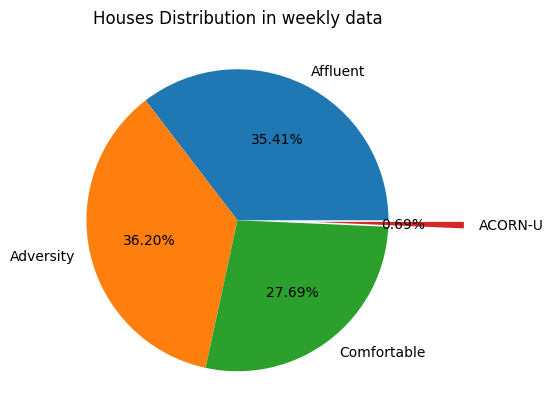

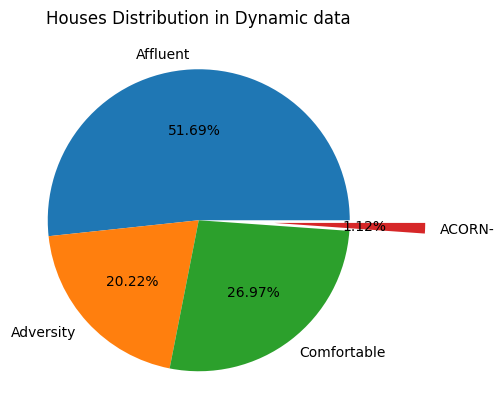

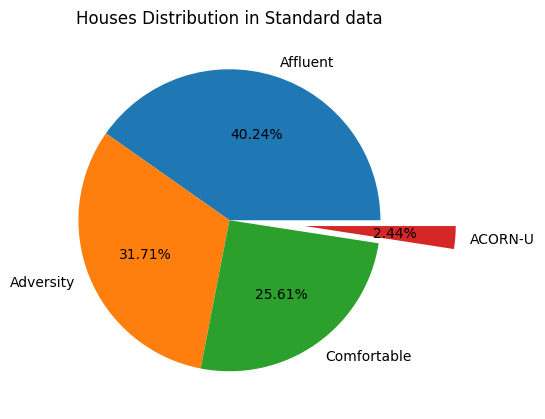

In [0]:
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='white', edgecolor='black')
plt.pie([1078, 1102, 843, 21], labels=['Affluent', 'Adversity', 'Comfortable', 'ACORN-U'], autopct='%.2f%%', explode=[0,0,0,0.5])
plt.title('Houses Distribution in weekly data')
plt.show()
print('\n')
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='white', edgecolor='black')
plt.pie([46,18,24, 1], labels=['Affluent', 'Adversity', 'Comfortable', 'ACORN-'], autopct='%.2f%%', explode=[0,0,0,0.5])
plt.title('Houses Distribution in Dynamic data')
plt.show()
print('\n')
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='white', edgecolor='black')
plt.pie([33,26,21, 2], labels=['Affluent', 'Adversity', 'Comfortable', 'ACORN-U'], autopct='%.2f%%', explode=[0,0,0,0.5])
plt.title('Houses Distribution in Standard data')
plt.show()

# Energy Usage Comparisons

In this section we will comparing how energy usage varies with different categorical variables and how different timings in the year give rise to different energy consumption patterns.

### Energy Consumption and Affluence Level

In [0]:
std_corrData = std_dataframe.copy()
Affluent = []
Adversity = []
Comfortable = []
ACORN_U = []
count=0
for ind in std_corrData.index:
    if (std_corrData["Acorn_grouped"][ind]=="Affluent"):
        Affluent.append(1)
        Adversity.append(0)
        Comfortable.append(0)
        ACORN_U.append(0)
    elif (std_corrData["Acorn_grouped"][ind]=="Adversity"):
        Affluent.append(0)
        Adversity.append(1)
        Comfortable.append(0)
        ACORN_U.append(0)
    elif (std_corrData["Acorn_grouped"][ind]=="Comfortable"):
        Affluent.append(0)
        Adversity.append(0)
        Comfortable.append(1)
        ACORN_U.append(0)
    elif (std_corrData["Acorn_grouped"][ind]=="ACORN-U"):
        Affluent.append(0)
        Adversity.append(0)
        Comfortable.append(0)
        ACORN_U.append(1)


             KWH/week  Affluent  Adversity  Comfortable   ACORN-U
KWH/week     1.000000  0.134399  -0.147308     0.012520  0.009444
Affluent     0.134399  1.000000  -0.559969    -0.459257 -0.061137
Adversity   -0.147308 -0.559969   1.000000    -0.463377 -0.061685
Comfortable  0.012520 -0.459257  -0.463377     1.000000 -0.050591
ACORN-U      0.009444 -0.061137  -0.061685    -0.050591  1.000000


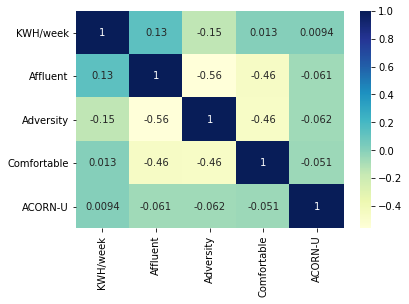

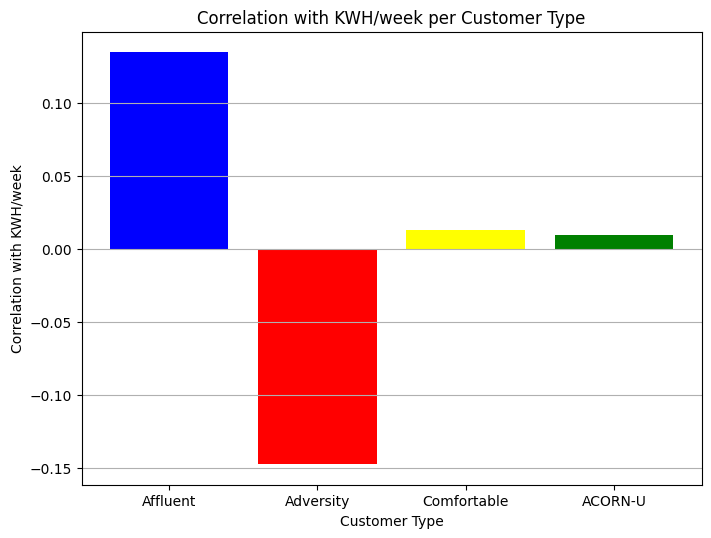

In [0]:
std_corrData['Affluent']= Affluent
std_corrData['Adversity']=Adversity
std_corrData['Comfortable']=Comfortable
std_corrData['ACORN-U']=ACORN_U

correlation = std_corrData.corr()
print(correlation)
ax = sns.heatmap(correlation, annot=True, cmap="YlGnBu")

y=[]
# y= (correlation['KWH/week'])
for i in range(1,5):
    y.append(correlation['KWH/week'][i])
x_axis = ['Affluent', 'Adversity','Comfortable','ACORN-U']
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
plt.bar(x_axis, y, color=['blue', 'red','yellow','green'], width=0.8)
plt.title('Correlation with KWH/week per Customer Type')
plt.ylabel('Correlation with KWH/week')
plt.xlabel('Customer Type')
plt.grid(b=None,axis='y')
plt.show()

### Energy Consumption with Customer Type

In [0]:
ToU_corrData = ToU_dataframe.copy()
Affluent = []
Adversity = []
Comfortable = []
ACORN_U = []
Normal= []
Low=[]
High=[]

count=0
for ind in ToU_corrData.index:
    if (ToU_corrData["Acorn_grouped"][ind]=="Affluent"):
        Affluent.append(1)
        Adversity.append(0)
        Comfortable.append(0)
        ACORN_U.append(0)
    elif (ToU_corrData["Acorn_grouped"][ind]=="Adversity"):
        Affluent.append(0)
        Adversity.append(1)
        Comfortable.append(0)
        ACORN_U.append(0)
    elif (ToU_corrData["Acorn_grouped"][ind]=="Comfortable"):
        Affluent.append(0)
        Adversity.append(0)
        Comfortable.append(1)
        ACORN_U.append(0)
    elif (ToU_corrData["Acorn_grouped"][ind]=="ACORN-U"):
        Affluent.append(0)
        Adversity.append(0)
        Comfortable.append(0)
        ACORN_U.append(1)
    elif (ToU_corrData["Acorn_grouped"][ind]=="ACORN-"):
        Affluent.append(0)
        Adversity.append(0)
        Comfortable.append(0)
        ACORN_U.append(1)
    else:
        print(ToU_corrData["Acorn_grouped"][ind])
    if (ToU_corrData["stdorToU"][ind]=="Normal"):
        Normal.append(1)
        High.append(0)
        Low.append(0)
    elif (ToU_corrData["stdorToU"][ind]=="Low"):
        Normal.append(0)
        High.append(0)
        Low.append(1)
    elif (ToU_corrData["stdorToU"][ind]=="High"):
        Normal.append(0)
        High.append(1)
        Low.append(0)
        


                         KWH/hh (per half hour)   Affluent  ...       Low      High
KWH/hh (per half hour)                  1.000000  0.052996  ...  0.022485  0.003703
Affluent                                0.052996  1.000000  ...  0.001191  0.000979
Adversity                              -0.068731 -0.517533  ...  0.001374 -0.000256
Comfortable                             0.004240 -0.649992  ... -0.001998 -0.000678
ACORN-U                                -0.015999 -0.103215  ... -0.002606 -0.000939
Normal                                 -0.021179 -0.001593  ... -0.800521 -0.541229
Low                                     0.022485  0.001191  ...  1.000000 -0.070676
High                                    0.003703  0.000979  ... -0.070676  1.000000

[8 rows x 8 columns]


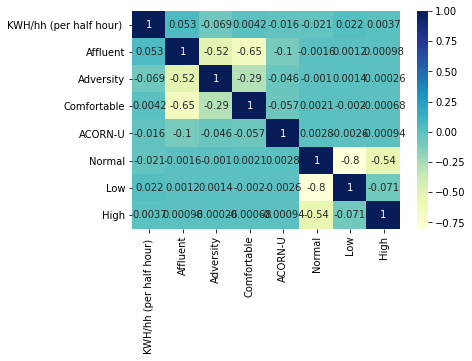

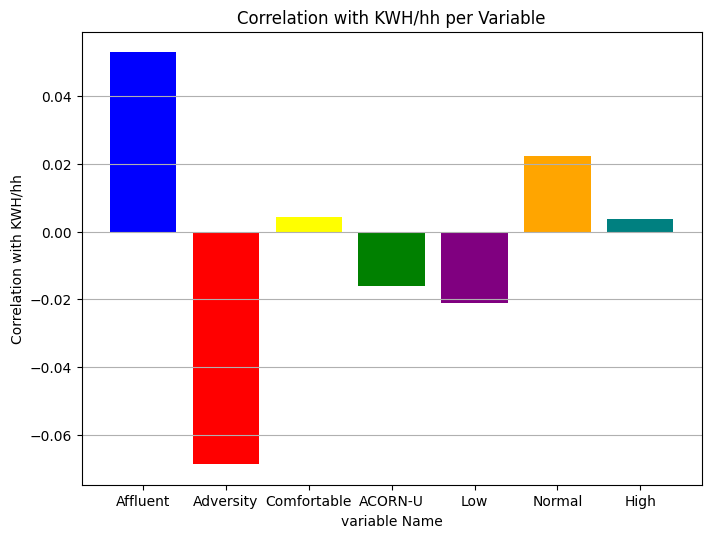

In [0]:
ToU_corrData['Affluent']= Affluent
ToU_corrData['Adversity']=Adversity
ToU_corrData['Comfortable']=Comfortable
ToU_corrData['ACORN-U']=ACORN_U
ToU_corrData['Normal'] = Normal
ToU_corrData['Low'] = Low
ToU_corrData['High'] = High

correlation = ToU_corrData.corr()
print(correlation)
ax = sns.heatmap(correlation, annot=True, cmap="YlGnBu")

y=[]
for i in range(1,8):
    y.append(correlation['KWH/hh (per half hour) '][i])
x_axis = ['Affluent', 'Adversity','Comfortable','ACORN-U','Low','Normal','High']
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
plt.bar(x_axis, y, color=['blue', 'red','yellow','green','purple','orange','teal'], width=0.8)
plt.title('Correlation with KWH/hh per Variable')
plt.ylabel('Correlation with KWH/hh')
plt.xlabel('variable Name')
plt.grid(b=None,axis='y')
plt.show()

### Average Energy Usage by each Month

In this section we will see how energy consumption varies throughout the year and then make comparisons with different customer groups and see how they stack up in comparison to the global average

In [0]:
def Monthly_Consumption(df):
    total_consumption = np.zeros(12)
    total_observations = np.zeros(12)
    for i in range(len(df)):
        current_date = df['DateTime'].iloc[i]
        month = current_date.month
        energy_consumption = df['KWH/week'].iloc[i]
        total_consumption[month-1] += energy_consumption
        total_observations[month-1] += 1
    
    average_consumption = np.divide(total_consumption, total_observations)
    return average_consumption

In [0]:
average_consumption_month = Monthly_Consumption(std_dataframe)

In [0]:
def plot_monthly_consumption(y):
    x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.plot(x_axis, y, '-ro')
    plt.title('Average Monthly Consumption')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Month')
    plt.grid()
    plt.show()

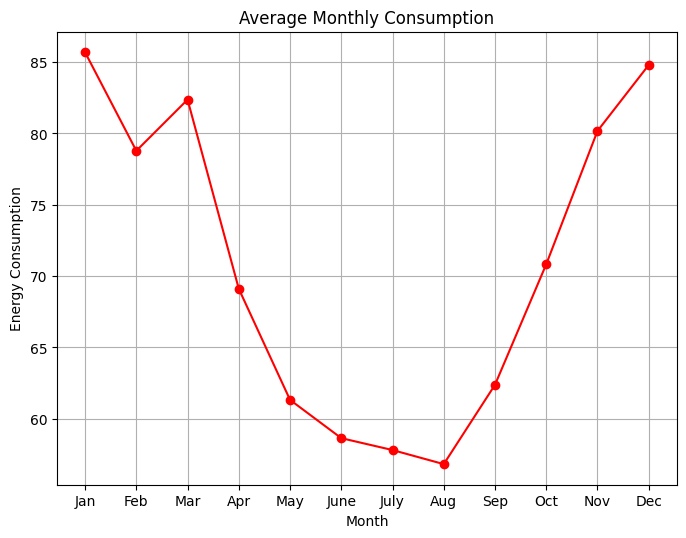

In [0]:
plot_monthly_consumption(average_consumption_month)

In [0]:
def affluency_monthly_consumption(df):
    groups = df.Acorn_grouped.unique()
    avg_consumption = []
    for group in groups:
        temp_dataframe = df[df['Acorn_grouped'] == group]
        avg_consumption.append(Monthly_Consumption(temp_dataframe))

    return avg_consumption

In [0]:
affluent_month_average = affluency_monthly_consumption(std_dataframe)

In [0]:
def plot_affluent_month_average(avg_consumption):
    x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.plot(x_axis, avg_consumption[0], '--ro', alpha=0.7)
    plt.plot(x_axis, avg_consumption[1], '--bo', alpha=0.7)
    plt.plot(x_axis, avg_consumption[2], '--go', alpha=0.7)
    plt.plot(x_axis, avg_consumption[3], '--yo', alpha=0.7)
    plt.plot(x_axis, average_consumption_month, color='black', marker='o', linewidth=2, alpha=0.4)
    plt.title('Average Monthly Consumption by Each Customer Group')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Month')
    plt.legend(['Affluent', 'Adversity', 'Comfortable', 'ACORN-U', 'Average'], loc='upper right')
    plt.grid()
    plt.show()


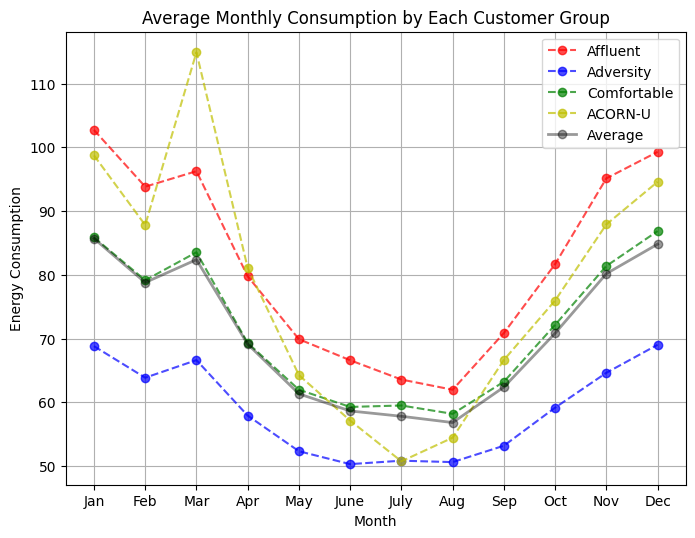

In [0]:
plot_affluent_month_average(affluent_month_average)

### Hourly Comparison 




In [0]:
def Hourly_Consumption(df):
    total_consumption = np.zeros(24)
    total_observations = np.zeros(24)
    for i in range(len(df)):
        current_date = df['DateTime'].iloc[i]
        hour = current_date.hour
        energy_consumption = df['KWH/hh (per half hour) '].iloc[i]
        total_consumption[hour] += energy_consumption
        total_observations[hour] += 1
    
    average_consumption = np.divide(total_consumption, total_observations)
    return average_consumption

In [0]:
average_hourly_consumption_std = Hourly_Consumption(hourly_dataframe)

In [0]:
def plot_hourly_consumption(y):
    x_axis = np.arange(24)
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.plot(x_axis, y, '-ro')
    plt.title('Average Hourly Consumption')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Hour of the Day')
    plt.grid()
    plt.show()

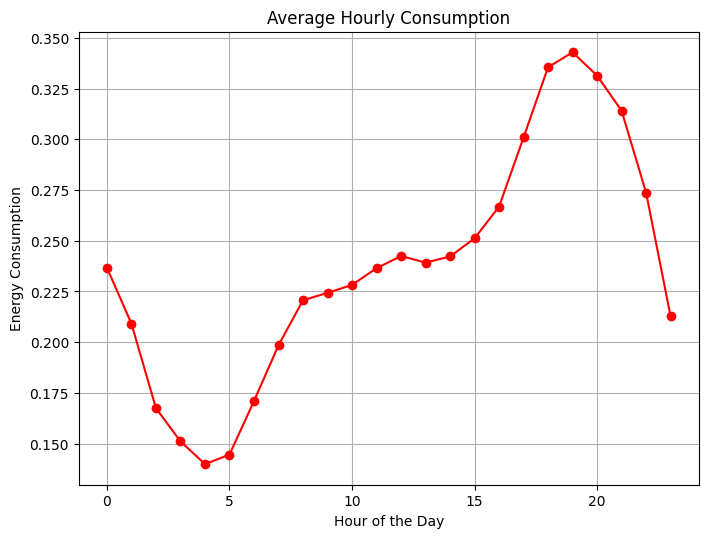

In [0]:
plot_hourly_consumption(average_hourly_consumption_std)

In [0]:
def affluency_hourly_consumption(df):
    groups = df.Acorn_grouped.unique()
    avg_consumption = []
    for group in groups:
        temp_dataframe = df[df['Acorn_grouped'] == group]
        avg_consumption.append(Hourly_Consumption(temp_dataframe))

    return avg_consumption

In [0]:
affluent_hourly_average = affluency_hourly_consumption(hourly_dataframe)

In [0]:
def plot_affluent_month_average(avg_consumption):
    x_axis = np.arange(24)
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.plot(x_axis, avg_consumption[0], '--ro', alpha=0.7)
    plt.plot(x_axis, avg_consumption[1], '--bo', alpha=0.7)
    plt.plot(x_axis, avg_consumption[2], '--go', alpha=0.7)
    plt.plot(x_axis, avg_consumption[3], '--yo', alpha=0.7)
    plt.plot(x_axis, average_hourly_consumption_std, color='black', marker='o', linewidth=2, alpha=0.4)
    plt.title('Average Hourly Consumption by Each Customer Group')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Hour of the Day')
    plt.legend(['Affluent', 'Adversity', 'Comfortable', 'ACORN-U', 'Average'], loc='upper left')
    plt.grid()
    plt.show()


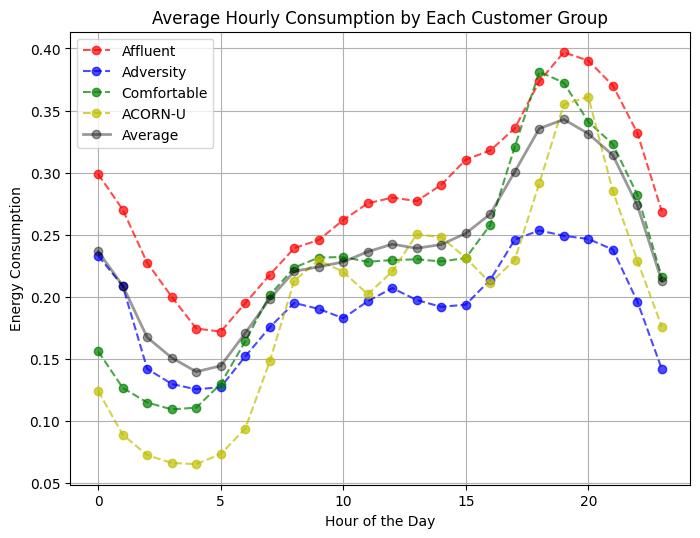

In [0]:
plot_affluent_month_average(affluent_hourly_average)

### Weekend vs Week Day Comparison

In [0]:
def Day_Comparison(df):
    total_consumption = np.zeros(2)
    total_observations = np.zeros(2)
    for i in range(len(df)):
        current_date = df['DateTime'].iloc[i]
        day = current_date.day_name()
        if(day != 'Saturday' and day != 'Sunday'):
            day = 0
        else:
            day = 1
        energy_consumption = df['KWH/hh (per half hour) '].iloc[i]
        total_consumption[day] += energy_consumption
        total_observations[day] += 1
    
    average_consumption = np.divide(total_consumption, total_observations)
    return average_consumption

In [0]:
daily_comparison = Day_Comparison(hourly_dataframe)

In [0]:
def plot_daily_consumption(y):
    x_axis = ['Weekday', 'Weekend']
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.bar(x_axis, y, color=['blue', 'red'], width=0.8)
    plt.title('Average Daily Consumption')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Day')
    plt.grid()
    plt.show()

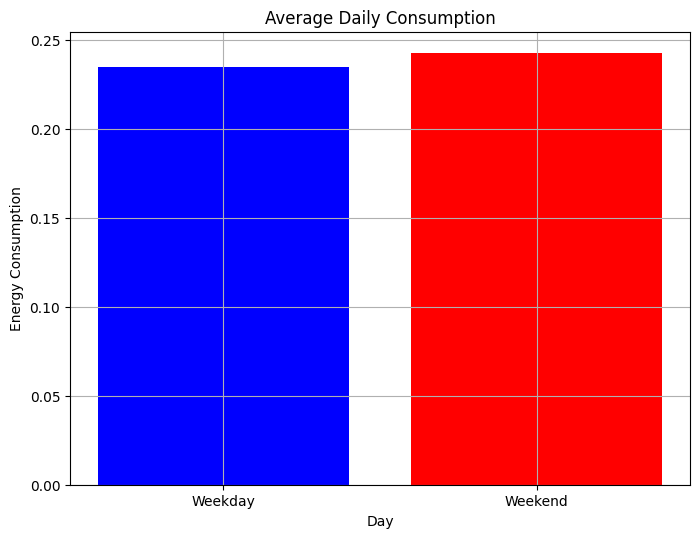

In [0]:
plot_daily_consumption(daily_comparison)

# DtoU Energy Usage Comparisons

### Average DToU Energy Consumption

In [0]:
def DToU_average_consumption(df):
    total_consumption = np.zeros(24)
    total_observations = np.zeros(24)
    for i in range(len(df)):
        current_date = df['DateTime'].iloc[i]
        hour = current_date.hour
        energy_consumption = df['KWH/hh (per half hour) '].iloc[i]
        total_consumption[hour] += energy_consumption
        total_observations[hour] += 1
    
    average_consumption = np.divide(total_consumption, total_observations)
    return average_consumption

In [0]:
DToU_hourly_consumption = DToU_average_consumption(ToU_dataframe)

In [0]:
def plot_DTou_avg_consumption(df):
    x_axis = np.arange(24)
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.plot(x_axis, df, '-bo')
    plt.title('Average DToU Consumption')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Hour of the Day')
    plt.grid()
    plt.show()

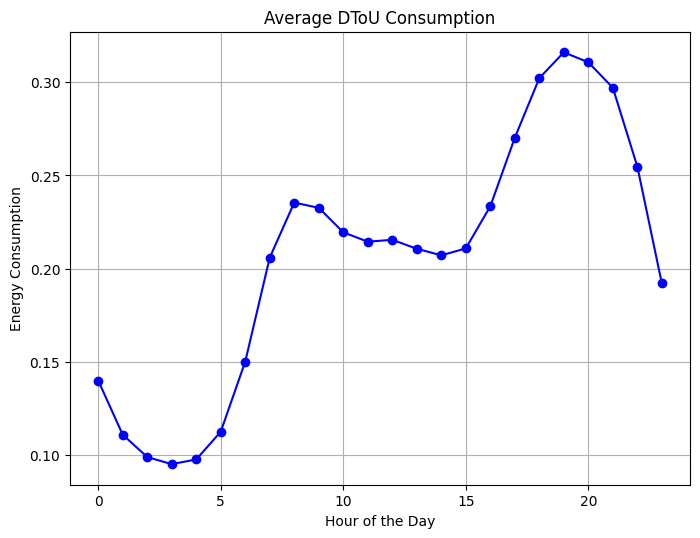

In [0]:
plot_DTou_avg_consumption(DToU_hourly_consumption)

### DToU Energy Consumption by Tarrif Rate


In [0]:
def DtoU_average_by_tarrif(df):
    groups = df.stdorToU.unique()
    avg_consumption = []
    for group in groups:
        temp_dataframe = df[df['stdorToU'] == group]
        avg_consumption.append(DToU_average_consumption(temp_dataframe))

    return avg_consumption



In [0]:
avg_consumption_by_tarrif = DtoU_average_by_tarrif(ToU_dataframe)

In [0]:
def plot_consumption_by_tarrif(df, dt):
    groups = dt.stdorToU.unique()
    s0 = groups[0]
    s1 = groups[1]
    s2 = groups[2]

    x_axis = np.arange(24)
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.plot(x_axis, df[0], '--yo', alpha=0.7)
    plt.plot(x_axis, df[1], '--bo', alpha=0.7)
    plt.plot(x_axis, df[2], '--go', alpha=0.7)
    plt.plot(x_axis, DToU_hourly_consumption, color='black', marker='o', linewidth=2, alpha=0.4)
    plt.title('Average Hourly DToU Consumption By Tarrif Rate')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Hour of the Day')


    plt.legend([s0, s1, s2, 'Average'], loc='lower right')
    plt.grid()
    plt.show()


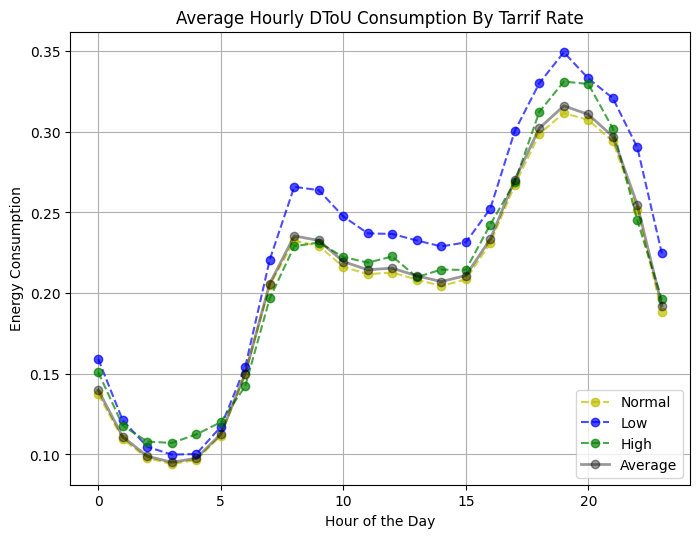

In [0]:
plot_consumption_by_tarrif(avg_consumption_by_tarrif, ToU_dataframe)

### Average DToU Energy Consumption by Tarrif Rate


In [0]:
def Bar_DtoU_average_by_tarrif(df):
    groups = df.stdorToU.unique()
    total_consumption = np.zeros(3)
    total_observations = np.zeros(3)


    for i in range(len(df)):
        if (df['stdorToU'].iloc[i] == groups[0]):
          total_consumption[0] += df['KWH/hh (per half hour) '].iloc[i] 
          total_observations[0] += 1
        if (df['stdorToU'].iloc[i] == groups[1]):
          total_consumption[1] += df['KWH/hh (per half hour) '].iloc[i] 
          total_observations[1] += 1
        if (df['stdorToU'].iloc[i] == groups[2]):
          total_consumption[2] += df['KWH/hh (per half hour) '].iloc[i] 
          total_observations[2] += 1
    avg = np.zeros(3)
    avg = np.divide(total_consumption, total_observations)
    
    return avg


In [0]:
barchart_avg = Bar_DtoU_average_by_tarrif(ToU_dataframe)

In [0]:
barc = [barchart_avg[0], barchart_avg[1],barchart_avg[2]]
thegroups = ToU_dataframe.stdorToU.unique()

In [0]:
def plot_bar_avg_consumption_by_tarrif(y):
    x_axis = [thegroups[0], thegroups[1], thegroups[2]]
    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='white', edgecolor='black')
    plt.bar(x_axis, y, color=['blue', 'red', 'green'], width=0.8)
    plt.title('Average Hourly DToU Consumption By Tarrif Rate')
    plt.ylabel('Energy Consumption')
    plt.xlabel('Tarrif Rates')
    plt.grid()
    plt.show()
    

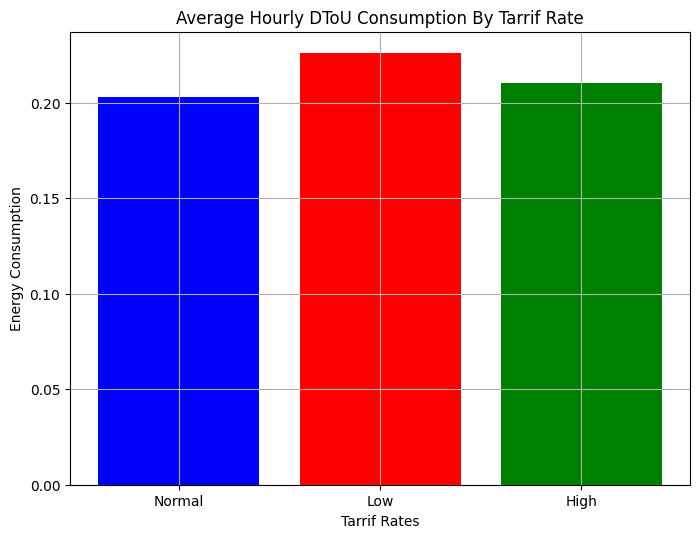

In [0]:
plot_bar_avg_consumption_by_tarrif(barc)

### Dynamic Energy Usage by Affluence Comparison

In [0]:
def dtou_tariff_affluence(df):
    groups = df.Acorn_grouped.unique()
    avg_consumption = []
    for group in groups:
        temp_dataframe = df[df['Acorn_grouped'] == group]
        avg_consumption.append(Bar_DtoU_average_by_tarrif(temp_dataframe))

    return avg_consumption

In [0]:
avg_affluence_tariff = dtou_tariff_affluence(ToU_dataframe)

In [0]:
ToU_dataframe['stdorToU'].unique()

array(['Normal', 'Low', 'High'], dtype=object)

In [0]:
def plot_dtou_tariff_affluence(y, group):
    x_axis = ToU_dataframe['stdorToU'].unique()
    plt.figure(num=None, figsize=(4,4), dpi=100, facecolor='white', edgecolor='black')
    plt.bar(x_axis, y, color=['blue', 'red', 'green'], width=0.8)
    plt.title('Average Hourly DToU Consumption for ' + group)
    plt.ylabel('Energy Consumption')
    plt.xlabel('Tarrif Rates')
    plt.grid()
    plt.show()
    print('\n')

In [0]:
ToU_dataframe['Acorn_grouped'].unique()

array(['Adversity', 'Affluent', 'Comfortable', 'ACORN-'], dtype=object)

In [0]:
def loop_plot():
    groups = ToU_dataframe['Acorn_grouped'].unique()
    for i in range(len(groups)):
        plot_dtou_tariff_affluence(avg_affluence_tariff[i], groups[i])


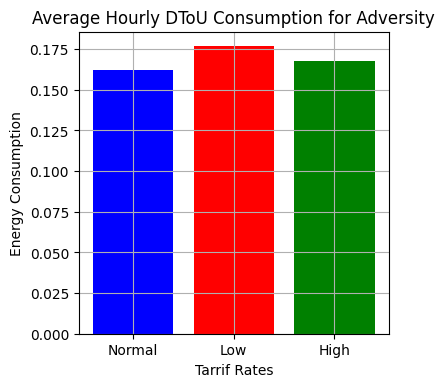

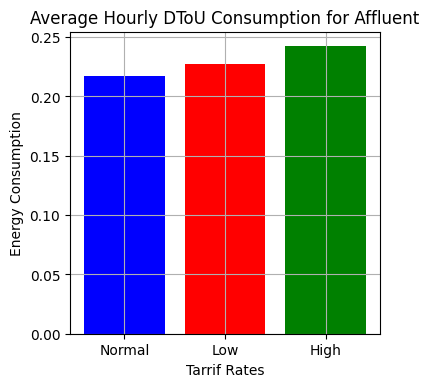

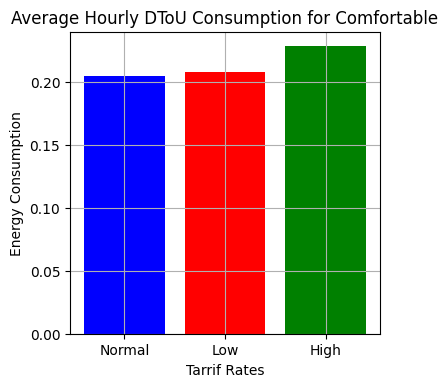

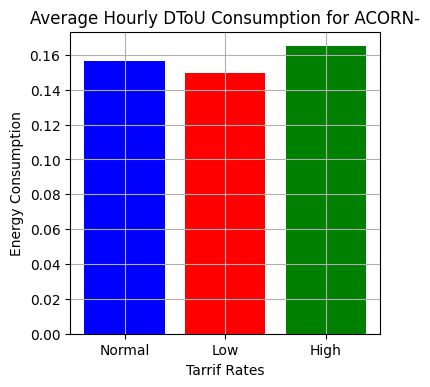

In [0]:
loop_plot()

# Cluster Analysis

In [0]:
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [0]:
def sumSeasons(df_to_use):
    sdf = np.zeros((3044, 4))
    winter, spring, summer, fall = [12,1,2], [3,4,5], [6,7,8], [9,10,11]

    curr_house = 0
    prev_house = df_to_use['LCLid'].iloc[0] 
    for i in range(len(df_to_use.index)):
        house = df_to_use['LCLid'].iloc[i]
        if(house != prev_house):
            curr_house += 1
            prev_house = df_to_use['LCLid'].iloc[i] 
        
        date = df_to_use['DateTime'].iloc[i]

        if(date.month in winter):
            sdf[curr_house][0] += df_to_use['KWH/week'].iloc[i]
        elif(date.month in spring):
            sdf[curr_house][1] += df_to_use['KWH/week'].iloc[i]
        elif(date.month in summer):
            sdf[curr_house][2] += df_to_use['KWH/week'].iloc[i]
        elif(date.month in fall):
            sdf[curr_house][3] += df_to_use['KWH/week'].iloc[i]
    
    return sdf

In [0]:
sdf = sumSeasons(std_dataframe)

In [0]:
index = std_dataframe['LCLid'].unique()
std_cluster_df = pd.DataFrame(sdf, index = index)
std_cluster_df.columns = ['Winter', 'Spring', 'Summer', 'Autumn']
std_cluster_df.head()

,Winter,Spring,Summer,Autumn
MAC000002,2428.027001,1082.450000,824.909000,1765.985000
MAC000003,5333.965000,3340.574001,2229.078000,3200.903002
MAC000004,331.533000,197.364000,277.058000,314.964000
MAC000006,645.342000,531.712000,445.952000,545.319000
MAC000007,1919.199000,928.044000,744.335999,1362.720000


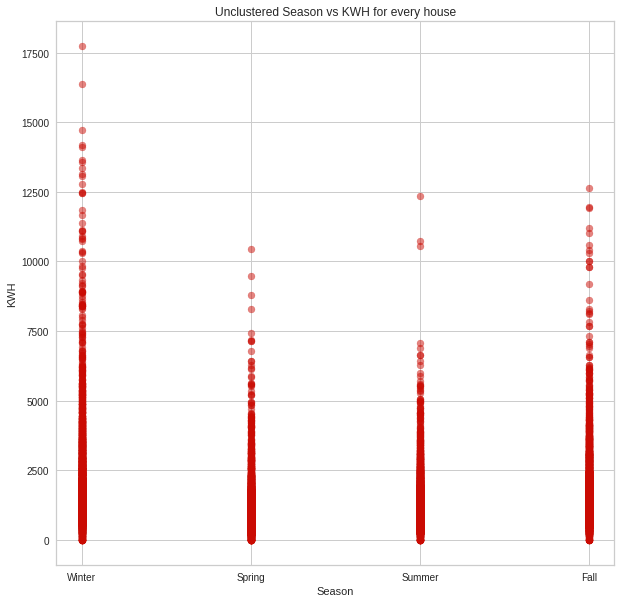

In [0]:
def plotscatter(df_to_use):
    plt.figure(figsize=(10,10), facecolor='white')

    for i in range(len(df_to_use.index)):
        plt.scatter(['Winter', 'Spring', 'Summer', 'Fall'], df_to_use.iloc[i], c='r', alpha=0.5)
        plt.xlabel('Season')
        plt.ylabel('KWH')
        plt.title("Unclustered Season vs KWH for every house")

    plt.grid(b=True, axis='y')
    plt.show()

plotscatter(std_cluster_df)

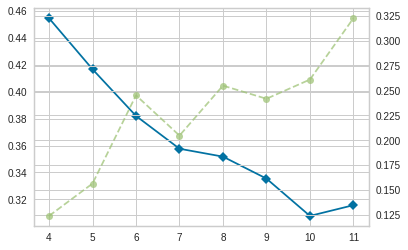

In [0]:
def plotElbow(df_to_use):
    X = df_to_use.values
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette')
    visualizer.fit(X)        # Fit the data to the visualizer

plotElbow(std_cluster_df)

In [0]:
def clustering(df_to_use):
    X = df_to_use.values
    df = df_to_use.copy()
    # labels = DBSCAN(eps=500, min_samples=2).fit_predict(X)
    kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
    return kmeans.labels_

In [0]:
labels = clustering(std_cluster_df)

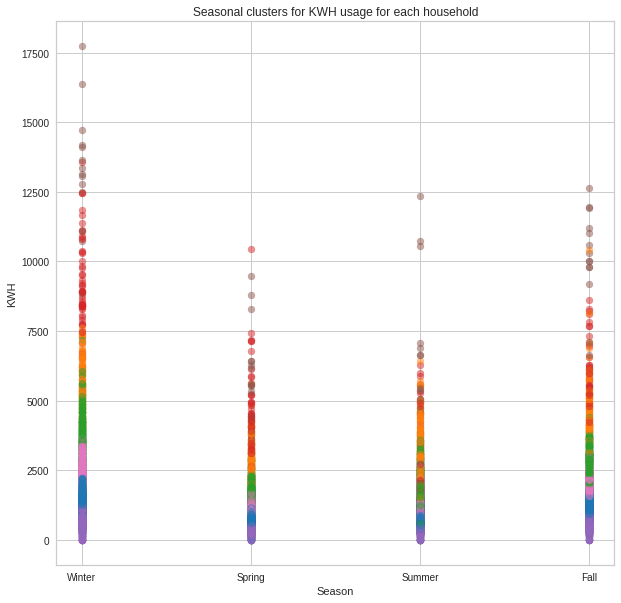

In [0]:
def plotClusters(df_to_use):
    plt.figure(figsize=(10,10), facecolor='white')

    for i in range(len(df_to_use.index)):
        plt.scatter(['Winter', 'Spring', 'Summer', 'Fall'], df_to_use.iloc[i], c=colors[labels[i]], alpha=0.5)
        plt.xlabel('Season')
        plt.ylabel('KWH')
        plt.title('Seasonal clusters for KWH usage for each household')

    # ax.scatter(df['Season'], df['KWH/week'], c=df['Labels'].astype(np.float), alpha=0.3)
    # ax.set_xlabel('Season')
    # ax.set_ylabel('KWH/week')
    # ax.set_xticks([1,2,3,4])
    # ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'])
    plt.grid(b=True, axis='y')
    plt.show()

plotClusters(std_cluster_df)

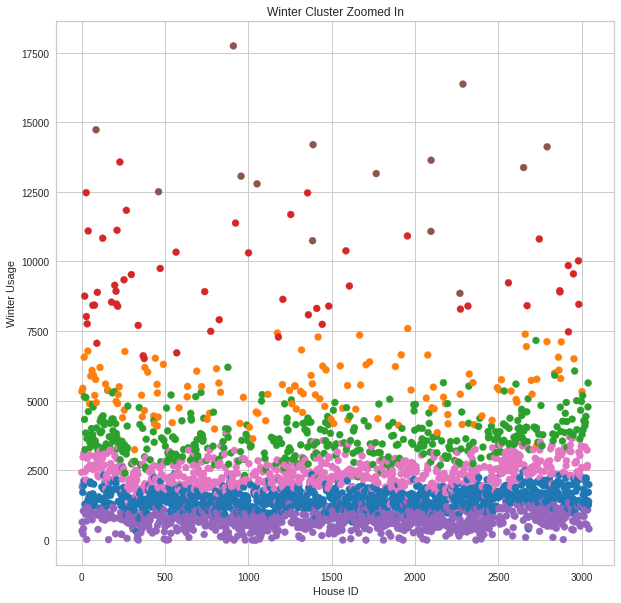

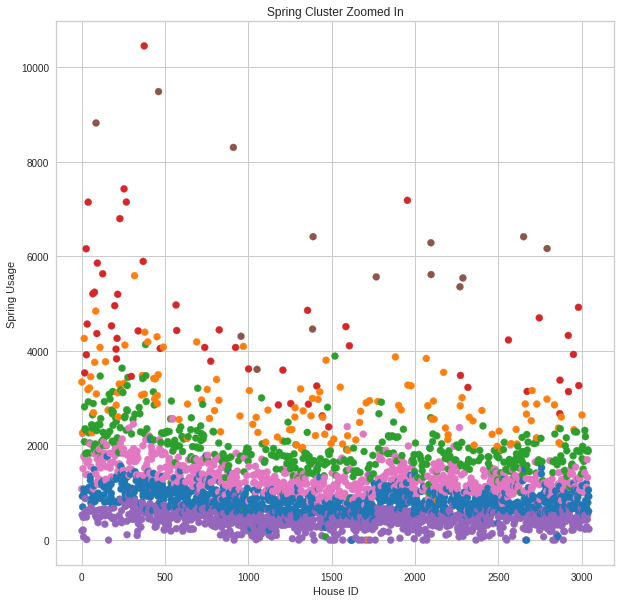

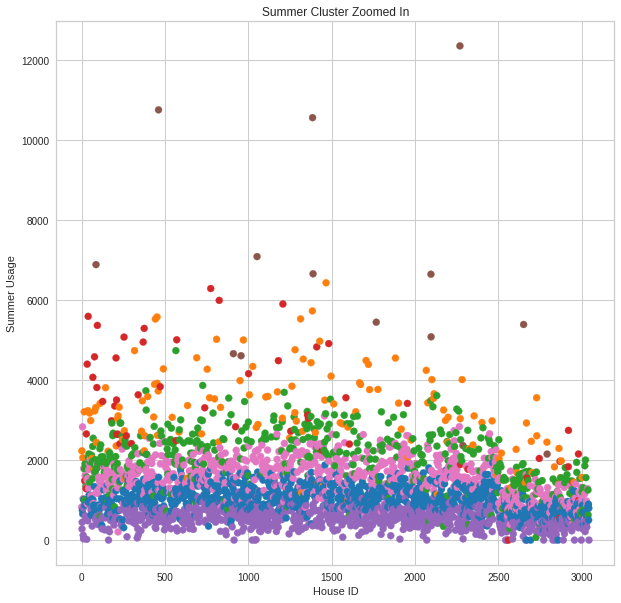

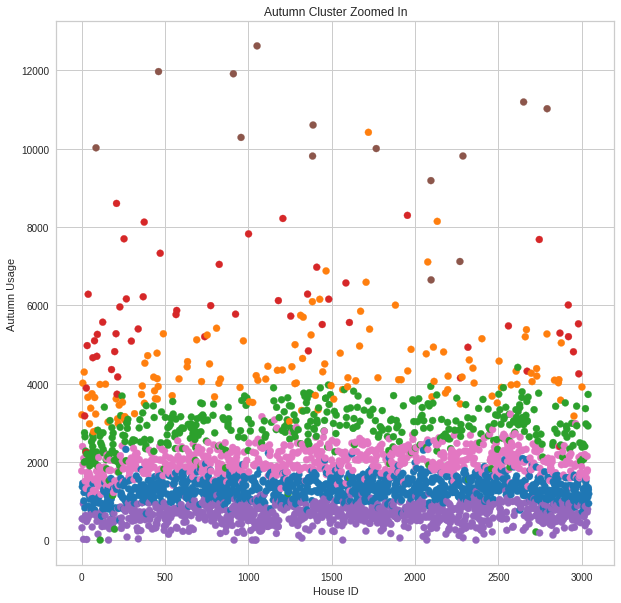

In [0]:
def plotSeason(season, df_to_use):
    plt.figure(figsize=(10,10), facecolor='white')
    neo_colors = []
    for i in range(len(labels)):
        neo_colors.append(colors[labels[i]])
    plt.scatter(range(1,3045), df_to_use[season], c=neo_colors)
    plt.grid(b=True, axis='y')
    plt.xlabel('House ID')
    plt.ylabel(season + ' Usage')
    plt.title(season+' Cluster Zoomed In')

plotSeason('Winter', std_cluster_df)
plotSeason('Spring', std_cluster_df)
plotSeason('Summer', std_cluster_df)
plotSeason('Autumn', std_cluster_df)

# Outlier Analysis

In [0]:
def plotAnamoly(labels,df,seasons):
    colorCode = {1:'green',-1:'black'}
    colors = [colorCode[x] for x in labels]
    size = len(df)
    for i in range(size):
        plt.scatter(['Winter', 'Spring', 'Summer', 'Fall'], df.iloc[i], c=colors[i], alpha=0.5)
    plt.xlabel('Season')
    plt.ylabel('KWH')
    plt.title('Seasonal clusters for KWH usage for each household')
    plt.show()
    
    for season in seasons:
        plt.scatter(range(1,3045), df[season], c = colors)
        plt.grid(b=True, axis='y')
        plt.xlabel('House ID')
        plt.ylabel(season + ' Usage')
        plt.title(season+' Cluster Zoomed In')
        plt.show()

### Isolation Forest

In [0]:
def IF(df):
    o = IsolationForest(max_samples = 1500)
    o.fit(df)
    return o.predict(df)

l = IF(std_cluster_df)
seasons = ['Winter', 'Spring', 'Autumn', 'Summer']
plotAnamoly(l,std_cluster_df, seasons)

### Local Outlier Factor (LOF)

In [0]:
def LOF(k, df):
    lof = LocalOutlierFactor(n_neighbors = k)
    return lof.fit_predict(df)

l = LOF(1,std_cluster_df)
seasons = ['Winter', 'Spring', 'Autumn', 'Summer']
plotAnamoly(l,std_cluster_df, seasons)